In [ ]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.32.2
    Uninstalling huggingface-hub-0.32.2:
      Successfully uninstalled huggingface-hub-0.32.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [ ]:
# Device-independent code
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [ ]:
!wget https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/datasets/eng_ita_v2.txt
#!wget https://github.com/mahsu/IndexingExercise/blob/master/5000-words.txt

--2025-06-06 08:51:48--  https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/datasets/eng_ita_v2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7240475 (6.9M) [text/plain]
Saving to: ‘eng_ita_v2.txt’

eng_ita_v2.txt      100%[===================>]   6.90M  --.-KB/s    in 0.04s   

2025-06-06 08:51:49 (164 MB/s) - ‘eng_ita_v2.txt’ saved [7240475/7240475]



In [ ]:
import numpy as np

# Function to read the file and extract pairs
def read_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.read().strip().split('\n')
    pairs = [[s for s in line.split(' -> ')] for line in lines]
    return pairs

"""with open("5000-words.txt", "r", encoding="utf-8") as f:
    vocab = set(w.strip().lower() for w in f if w.strip())"""

'with open("5000-words.txt", "r", encoding="utf-8") as f:\n    vocab = set(w.strip().lower() for w in f if w.strip())'

In [ ]:
"""import re

word_re = re.compile(r"\b[a-zA-Z']+\b")

def is_valid_pair(ex):
    eng = ex["english"].strip()
    esp = ex["non_english"].strip()
    if not eng or not esp:
        return False                # drop if either side is empty
    words = word_re.findall(eng.lower())
    if not words:
        return False                # drop if no valid word tokens
    return all(w in vocab for w in words)

filtered = dataset.filter(is_valid_pair)"""

Filter:   0%|          | 0/13646844 [00:00<?, ? examples/s]

In [ ]:
"""print(len(filtered))
for ex in filtered.select(range(5)):
    print("English:", ex["english"])
    print("Spanish:", ex["non_english"])
    print()"""

316
English: "New star...
Spanish: "Nueva estrella...

English: PARTNERS?
Spanish: ¿Socios?

English: PARTNERS.
Spanish: Socios.

English: New.
Spanish: Diferente.

English: Security.
Spanish: Seguridad.



In [ ]:
"""filtered.save_to_disk("filtered_enes5000")"""

Saving the dataset (0/1 shards):   0%|          | 0/316 [00:00<?, ? examples/s]

In [ ]:
# Path to text file

file_path = 'eng_ita_v2.txt'

# Process the data
pairs = read_data(file_path)
len(pairs)


120746

In [ ]:
# Create vocabulary
def tokenize(sentence):
  return sentence.lower().split()

# Tokenize and build vocabularies
def build_vocab(pairs):
    eng_vocab = set()
    ita_vocab = set()
    for eng, ita in pairs:
        eng_vocab.update(tokenize(eng))
        ita_vocab.update(tokenize(ita))
    return eng_vocab, ita_vocab

english_vocab, italian_vocab = build_vocab(pairs)

# Creating word to integer mapping
eng_word2int = {word: i for i, word in enumerate(english_vocab)}
ita_word2int = {word: i for i, word in enumerate(italian_vocab)}

# Creating integer to word mapping
eng_int2word = {i: word for word, i in eng_word2int.items()}
ita_int2word = {i: word for word, i in ita_word2int.items()}

print('English vocabulary size:', len(english_vocab))
print('Italian vocabulary size:', len(italian_vocab))

English vocabulary size: 4997
Italian vocabulary size: 13673


In [ ]:
# Example usage
eng_example = "Who are you"
ita_example = "chi sei tu"

# Encoding
eng_encoded = np.array([eng_word2int[word] for word in tokenize(eng_example)], dtype=np.int32)
ita_encoded = np.array([ita_word2int[word] for word in tokenize(ita_example)], dtype=np.int32)

print('English text encoded:', eng_encoded)
print('Italian text encoded:', ita_encoded)

# Decoding
print('Decoded English:', ' '.join([eng_int2word[i] for i in eng_encoded]))
print('Decoded Italian:', ' '.join([ita_int2word[i] for i in ita_encoded]))

English text encoded: [2227 3909 3873]
Italian text encoded: [ 9572 10568  5313]
Decoded English: who are you
Decoded Italian: chi sei tu


In [ ]:
# Special tokens
PAD_TOKEN = "<PAD>"
EOS_TOKEN = "<EOS>"
SOS_TOKEN = "<SOS>"
UNK_TOKEN = "<UNK>"

# Update the function to create mappings to include the special tokens
def create_mappings(vocab):
    vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + sorted(vocab)
    word2int = {word: i for i, word in enumerate(vocab)}
    int2word = {i: word for word, i in word2int.items()}
    return word2int, int2word

# Update the vocabularies
eng_word2int, eng_int2word = create_mappings(english_vocab)
ita_word2int, ita_int2word = create_mappings(italian_vocab)

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, pairs, eng_word2int, ita_word2int):
        self.pairs = pairs
        self.eng_word2int = eng_word2int
        self.ita_word2int = ita_word2int

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        eng, ita = self.pairs[idx]
        eng_tensor = torch.tensor([self.eng_word2int[word] for word in tokenize(eng)]
                                  + [self.eng_word2int[EOS_TOKEN]], dtype=torch.long)
        ita_tensor = torch.tensor([self.ita_word2int[word] for word in tokenize(ita)]
                                  + [self.ita_word2int[EOS_TOKEN]], dtype=torch.long)
        return eng_tensor, ita_tensor

# Custom collate function to handle padding
def collate_fn(batch):
    eng_batch, ita_batch = zip(*batch)
    eng_batch_padded = pad_sequence(eng_batch, batch_first=True, padding_value=eng_word2int[PAD_TOKEN])
    ita_batch_padded = pad_sequence(ita_batch, batch_first=True, padding_value=ita_word2int[PAD_TOKEN])
    return eng_batch_padded, ita_batch_padded

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# Create the dataset and DataLoader
translation_dataset = TranslationDataset(pairs, eng_word2int, ita_word2int)
batch_size = 64
translation_dataloader = DataLoader(translation_dataset, batch_size=batch_size,
                                    shuffle=True,  drop_last=True, collate_fn=collate_fn)

print("Translation samples: ", len(translation_dataset))
print("Translation batches: ", len(translation_dataloader))

Translation samples:  120746
Translation batches:  1886


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers,
                            batch_first=True)

    def forward(self, x):
        # Reversing the sequence of indices
        x = torch.flip(x, [1])
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x)
        out, (hidden, cell) = self.lstm(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

In [ ]:
# Hyperparameters
eng_vocab_size = len(eng_word2int)
ita_vocab_size = len(ita_word2int)
embed_size = 256
hidden_size = 512
num_layers = 1

# Initialize the models
encoder = Encoder(eng_vocab_size, embed_size, hidden_size, num_layers).to(DEVICE)
decoder = Decoder(ita_vocab_size, embed_size, hidden_size, num_layers).to(DEVICE)

In [ ]:
def translate(encoder, decoder, sentence, eng_word2int, ita_int2word, max_length=15):
    encoder.eval()
    decoder.eval()
    with torch.inference_mode():
        # Tokenize and encode the sentence
        input_tensor = torch.tensor([eng_word2int[word] for word in tokenize(sentence)]
                                    + [eng_word2int[EOS_TOKEN]], dtype=torch.long)
        input_tensor = input_tensor.view(1, -1).to(DEVICE)  # batch_first=True

        # Pass the input through the encoder
        _, encoder_hidden, encoder_cell = encoder(input_tensor)

        # Initialize the decoder input with the SOS token
        decoder_input = torch.tensor([[eng_word2int[SOS_TOKEN]]], dtype=torch.long)  # SOS
        # Initialize the hidden state of the decoder with the encoder's hidden state
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

        # Decoding the sentence
        decoded_words = []
        last_word = torch.tensor([[eng_word2int[SOS_TOKEN]]]).to(DEVICE)
        for di in range(max_length):
            logits, decoder_hidden, decoder_cell = decoder(last_word, decoder_hidden, decoder_cell)
            next_token = logits.argmax(dim=1) # greedy
            last_word = torch.tensor([[next_token]]).to(DEVICE)
            if next_token.item() == ita_word2int[EOS_TOKEN]:
                break
            else:
                decoded_words.append(ita_int2word.get(next_token.item()))

        return ' '.join(decoded_words)

# **Train**

In [ ]:
import torch.optim as optim
import torch.nn as nn
import random

# Loss Function (exclude padding)
loss_fn = nn.CrossEntropyLoss(ignore_index=eng_word2int[PAD_TOKEN])

# Optimizers
encoder_optimizer = optim.AdamW(encoder.parameters())
decoder_optimizer = optim.AdamW(decoder.parameters())

# Number of epochs
num_epochs = 10

# Training Loop
encoder.train()
decoder.train()

for epoch in range(num_epochs):
    for i, (input_tensor, target_tensor) in enumerate(translation_dataloader):
        input_tensor, target_tensor = input_tensor.to(DEVICE), target_tensor.to(DEVICE)

        # Zero gradients of both optimizers
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        target_length = target_tensor.size(1)

        # Encoder
        _, encoder_hidden, encoder_cell = encoder(input_tensor)

        # Decoder
        decoder_input = torch.full((batch_size, 1), eng_word2int[SOS_TOKEN], dtype=torch.long).to(DEVICE)
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        # Randomly select a word index from the target sequence
        random_word_index = random.randint(0, target_length - 1)

        loss = 0

        for di in range(target_length):
            logits, decoder_hidden, decoder_cell  = decoder(decoder_input, decoder_hidden, decoder_cell)
            #if di == random_word_index:
            #    loss = loss_fn(logits, target_tensor[:, di])
            #    break  # Only compute loss for the randomly selected word
            loss += loss_fn(logits, target_tensor[:,di])
            decoder_input = target_tensor[:, di].reshape(batch_size, 1)  # Teacher forcing


        # Backpropagation
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        if i % 100 == 0:  # Print loss every 10 batches
            print(f'Epoch {epoch}, Batch {i}, Loss: {loss.item() / target_length:.4f}')


Epoch 0, Batch 0, Loss: 9.5151
Epoch 0, Batch 100, Loss: 4.5478
Epoch 0, Batch 200, Loss: 3.8440
Epoch 0, Batch 300, Loss: 4.1583
Epoch 0, Batch 400, Loss: 4.4469
Epoch 0, Batch 500, Loss: 3.7718
Epoch 0, Batch 600, Loss: 3.6907
Epoch 0, Batch 700, Loss: 3.4962
Epoch 0, Batch 800, Loss: 3.0509
Epoch 0, Batch 900, Loss: 3.1923
Epoch 0, Batch 1000, Loss: 2.5373
Epoch 0, Batch 1100, Loss: 2.5597
Epoch 0, Batch 1200, Loss: 3.0508
Epoch 0, Batch 1300, Loss: 3.0945
Epoch 0, Batch 1400, Loss: 3.1476
Epoch 0, Batch 1500, Loss: 2.9080
Epoch 0, Batch 1600, Loss: 2.3722
Epoch 0, Batch 1700, Loss: 2.5164
Epoch 0, Batch 1800, Loss: 3.3248
Epoch 1, Batch 0, Loss: 2.0162
Epoch 1, Batch 100, Loss: 2.2122
Epoch 1, Batch 200, Loss: 1.9310
Epoch 1, Batch 300, Loss: 2.2210
Epoch 1, Batch 400, Loss: 2.0728
Epoch 1, Batch 500, Loss: 2.2646
Epoch 1, Batch 600, Loss: 1.6760
Epoch 1, Batch 700, Loss: 2.1958
Epoch 1, Batch 800, Loss: 2.0306
Epoch 1, Batch 900, Loss: 1.5589
Epoch 1, Batch 1000, Loss: 2.1283
Epoc

In [ ]:
torch.save(encoder.state_dict(), "encoder_weights.pt")
torch.save(decoder.state_dict(), "decoder_weights.pt")

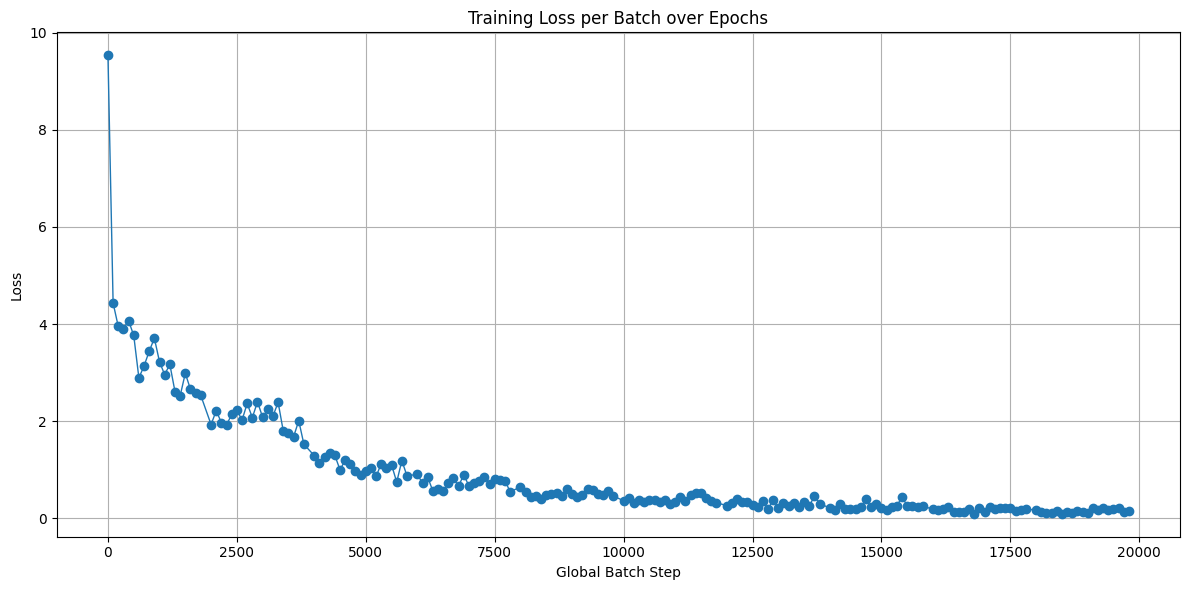

In [ ]:
import matplotlib.pyplot as plt

# Data: (epoch, batch, loss)
data = [
    (0, 0, 9.5360), (0, 100, 4.4330), (0, 200, 3.9501), (0, 300, 3.8989), (0, 400, 4.0696), (0, 500, 3.7652),
    (0, 600, 2.8907), (0, 700, 3.1378), (0, 800, 3.4398), (0, 900, 3.7092), (0, 1000, 3.2223), (0, 1100, 2.9589),
    (0, 1200, 3.1708), (0, 1300, 2.6093), (0, 1400, 2.5218), (0, 1500, 2.9872), (0, 1600, 2.6564), (0, 1700, 2.5744),
    (0, 1800, 2.5317), (1, 0, 1.9298), (1, 100, 2.2183), (1, 200, 1.9669), (1, 300, 1.9175), (1, 400, 2.1452),
    (1, 500, 2.2371), (1, 600, 2.0181), (1, 700, 2.3665), (1, 800, 2.0723), (1, 900, 2.3999), (1, 1000, 2.0791),
    (1, 1100, 2.2464), (1, 1200, 2.1045), (1, 1300, 2.3880), (1, 1400, 1.7967), (1, 1500, 1.7661), (1, 1600, 1.6798),
    (1, 1700, 2.0095), (1, 1800, 1.5248), (2, 0, 1.2919), (2, 100, 1.1479), (2, 200, 1.2680), (2, 300, 1.3421),
    (2, 400, 1.2990), (2, 500, 0.9971), (2, 600, 1.1966), (2, 700, 1.1156), (2, 800, 0.9643), (2, 900, 0.8924),
    (2, 1000, 0.9818), (2, 1100, 1.0293), (2, 1200, 0.8633), (2, 1300, 1.1247), (2, 1400, 1.0458), (2, 1500, 1.1008),
    (2, 1600, 0.7458), (2, 1700, 1.1897), (2, 1800, 0.8686), (3, 0, 0.9117), (3, 100, 0.7177), (3, 200, 0.8511),
    (3, 300, 0.5637), (3, 400, 0.6051), (3, 500, 0.5556), (3, 600, 0.7343), (3, 700, 0.8202), (3, 800, 0.6624),
    (3, 900, 0.8995), (3, 1000, 0.6662), (3, 1100, 0.7197), (3, 1200, 0.7777), (3, 1300, 0.8428), (3, 1400, 0.7056),
    (3, 1500, 0.8112), (3, 1600, 0.7972), (3, 1700, 0.7760), (3, 1800, 0.5446), (4, 0, 0.6468), (4, 100, 0.5314),
    (4, 200, 0.4478), (4, 300, 0.4498), (4, 400, 0.4039), (4, 500, 0.4851), (4, 600, 0.5058), (4, 700, 0.5188),
    (4, 800, 0.4613), (4, 900, 0.6002), (4, 1000, 0.4961), (4, 1100, 0.4399), (4, 1200, 0.4740), (4, 1300, 0.5996),
    (4, 1400, 0.5889), (4, 1500, 0.5002), (4, 1600, 0.4712), (4, 1700, 0.5631), (4, 1800, 0.4612), (5, 0, 0.3608),
    (5, 100, 0.4270), (5, 200, 0.3174), (5, 300, 0.3766), (5, 400, 0.3458), (5, 500, 0.3813), (5, 600, 0.3698),
    (5, 700, 0.3322), (5, 800, 0.3707), (5, 900, 0.2907), (5, 1000, 0.3460), (5, 1100, 0.4332), (5, 1200, 0.3502),
    (5, 1300, 0.4831), (5, 1400, 0.5178), (5, 1500, 0.5168), (5, 1600, 0.4231), (5, 1700, 0.3594), (5, 1800, 0.3209),
    (6, 0, 0.2619), (6, 100, 0.3123), (6, 200, 0.3918), (6, 300, 0.3285), (6, 400, 0.3301), (6, 500, 0.2789),
    (6, 600, 0.2427), (6, 700, 0.3597), (6, 800, 0.1834), (6, 900, 0.3827), (6, 1000, 0.2074), (6, 1100, 0.3172),
    (6, 1200, 0.2527), (6, 1300, 0.3097), (6, 1400, 0.2355), (6, 1500, 0.3299), (6, 1600, 0.2467), (6, 1700, 0.4610),
    (6, 1800, 0.3039), (7, 0, 0.2115), (7, 100, 0.1755), (7, 200, 0.2869), (7, 300, 0.1873), (7, 400, 0.1974),
    (7, 500, 0.1961), (7, 600, 0.2290), (7, 700, 0.3896), (7, 800, 0.2226), (7, 900, 0.2974), (7, 1000, 0.2146),
    (7, 1100, 0.1739), (7, 1200, 0.2350), (7, 1300, 0.2555), (7, 1400, 0.4435), (7, 1500, 0.2538), (7, 1600, 0.2544),
    (7, 1700, 0.2312), (7, 1800, 0.2542), (8, 0, 0.1839), (8, 100, 0.1669), (8, 200, 0.1949), (8, 300, 0.2331),
    (8, 400, 0.1321), (8, 500, 0.1199), (8, 600, 0.1275), (8, 700, 0.1909), (8, 800, 0.0928), (8, 900, 0.2041),
    (8, 1000, 0.1379), (8, 1100, 0.2280), (8, 1200, 0.1960), (8, 1300, 0.2116), (8, 1400, 0.2163), (8, 1500, 0.2132),
    (8, 1600, 0.1594), (8, 1700, 0.1673), (8, 1800, 0.1991), (9, 0, 0.1618), (9, 100, 0.1364), (9, 200, 0.1121),
    (9, 300, 0.1110), (9, 400, 0.1555), (9, 500, 0.0963), (9, 600, 0.1199), (9, 700, 0.1187), (9, 800, 0.1534),
    (9, 900, 0.1313), (9, 1000, 0.1145), (9, 1100, 0.2104), (9, 1200, 0.1728), (9, 1300, 0.2201), (9, 1400, 0.1665),
    (9, 1500, 0.1830), (9, 1600, 0.2089), (9, 1700, 0.1394), (9, 1800, 0.1515)
]

# Convert data into plottable form
global_step = []
losses = []
for epoch, batch, loss in data:
    global_step.append(epoch * 2000 + batch)  # simple way to make x-axis continuous
    losses.append(loss)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(global_step, losses, marker='o', linestyle='-', linewidth=1)
plt.title("Training Loss per Batch over Epochs")
plt.xlabel("Global Batch Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import os

# List all files in the current directory
for file in os.listdir():
    print(file)

.config
eng_ita_v2.txt
encoder_weights.pt
decoder_weights.pt
sample_data


# Load and **test**

In [ ]:
# First re-create the model architecture with same parameters
encoder = Encoder(eng_vocab_size, embed_size, hidden_size, num_layers).to(DEVICE)
decoder = Decoder(ita_vocab_size, embed_size, hidden_size, num_layers).to(DEVICE)

# Move to device if needed
encoder.to(DEVICE)
decoder.to(DEVICE)

# Then load the saved weights
encoder.load_state_dict(torch.load("encoder_weights.pt"))
decoder.load_state_dict(torch.load("decoder_weights.pt"))

encoder.eval()
decoder.eval()

Decoder(
  (embedding): Embedding(13677, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=13677, bias=True)
)

In [ ]:
sentence = "i love my friend Tom"
translated_sentence = translate(encoder, decoder, sentence, eng_word2int, ita_int2word)
print("Translated:", translated_sentence)

Translated: amo il mio amico tom
